In [49]:
import sys
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv
load_dotenv()
import plotly_express as px
import os
from typing import Union
from datetime import datetime, timedelta
import pandas as pd

from omegaconf import OmegaConf
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import ast

cwd = os.getcwd()
parent_dir = os.path.dirname(os.path.dirname(cwd))
sys.path.append(parent_dir)

from src.data_management import get_data_by_dates


In [58]:
start_date= "2021_12_21"
as_dt = datetime.strptime(start_date, "%Y_%m_%d")
val_dict = {
    "date":[], # "2021_12_21
    "min_intensity":[],
    "max_intensity":[],
    "min_volatility":[],
    "max_volatility":[],
}
while True:
    try:
        df = get_data_by_dates(as_dt)
        val_dict["date"].append(as_dt.strftime("%Y_%m_%d"))
        val_dict["min_intensity"].append(df["intensity"].min())
        val_dict["max_intensity"].append(df["intensity"].max())
        val_dict["min_volatility"].append(df["volatility"].min())
        val_dict["max_volatility"].append(df["volatility"].max())
        as_dt += timedelta(days=1)
    except Exception as e:
        print(e)
        break


Error reading file: [Errno 2] No such file or directory: '/Volumes/ssd/gradu_data/parsed/2022_02_04/data.csv'


In [60]:
pd.DataFrame(val_dict).describe()

,min_intensity,max_intensity,min_volatility,max_volatility
count,45.000000,45.000000,45.000000,45.000000
mean,6140.218534,8664.303365,0.001309,0.001809
std,4604.036432,5874.439554,0.000426,0.000737
min,0.077304,7.675924,0.000547,0.000776
25%,1.666894,6270.497261,0.000979,0.001281
50%,6541.052600,9043.054462,0.001264,0.001713
75%,7754.958502,11303.834580,0.001620,0.002025
max,16629.453908,21375.949138,0.002336,0.004071


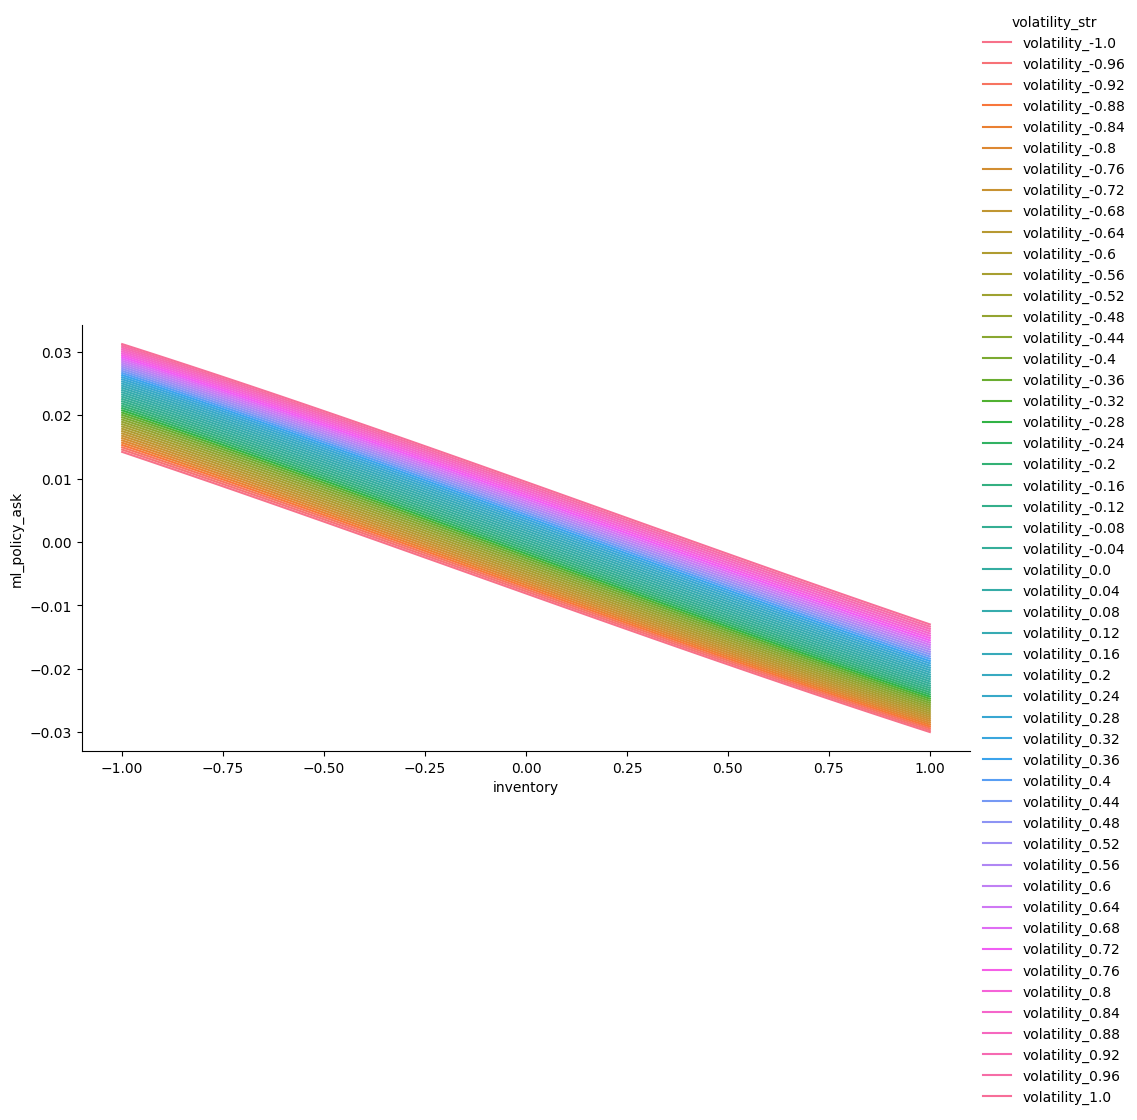

In [38]:
df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/decision_grid.csv")
df['volatility_str'] = 'volatility_' + df['volatility'].astype(str)
# df["intensity_str"] = "intensity_" + df["intensity"].astype(str)
g = sns.FacetGrid(df, hue="volatility_str", height=5, aspect=2)
g = g.map(plt.plot, "inventory", "ml_policy_ask")
g.add_legend()

# plt.show()
# px.line(df, x="volatility", y=['ml_policy_bid', 'as_policy_bid'])
# px.line(df, x="volatility", y=['ml_policy_ask', 'as_policy_ask','ml_policy_bid', 'as_policy_bid'])
# px.line(df, x="inventory", y=['ml_policy_ask','ml_policy_bid'])

In [3]:
def aggregation_function_rewards(df):
    grouping = {
    "sharpe_min":('sharpe', 'min'),
    "sharpe_max":('sharpe', 'max'),
    "sharpe_std":('sharpe', 'std'),
    "sharpe_var":('sharpe', 'var'),
    "sharpe_mean":('sharpe', 'mean'),
    "max_inventory_all": ('max_inventory', 'max'),
    }

    df_grouped = df.groupby('trial_group').agg(
        **{col:(col,'mean') for col in df.columns if col != 'trial_group'},
        **grouping
    ).reset_index()

    df_grouped.sort_values('sharpe', ascending=False)
    # filter out liquidated
    df_grouped = df_grouped[df_grouped.max_inventory_all < 1]
    # filter out low returns (NOTE: This depends on evaluation data)
    df_grouped = df_grouped[df_grouped.episode_return > 0.01]
    return df_grouped


path = "/Volumes/ssd/gradu_data/exported_trial_results"
results = []
params = []
n = 0
for i in os.listdir(path):
    joined = os.path.join(path, i)
    if i[-4:] == 'lock':
        # remove
        os.remove(joined)
    elif "override" in i:
        continue
    else:
        if i[0] == 'p':
            name = i[11:-22:]
        else:
            name = i[8: -22:]
        df = pd.read_csv(joined)
        if "results" in i:
            grouped_df = aggregation_function_rewards(df)
            original = len(df)
            grouped = len(grouped_df)
            grouped_df['reward_func'] = name
            print(f"index: {n}, reward: {name}, original: {original}, grouped: {grouped}, ratio: {round(grouped/original,2)}")
            results.append(grouped_df)
            n += 1
        else:
            params.append(df)

all_rewards = pd.concat(results)
all_params = pd.concat(params)

index: 0, reward: assymetric_pnl_dampening, original: 485, grouped: 11, ratio: 0.02
index: 1, reward: delta_inventory_pn, original: 374, grouped: 6, ratio: 0.02
index: 2, reward: inventory_integral_penalty, original: 290, grouped: 3, ratio: 0.01
index: 3, reward: inventory, original: 234, grouped: 3, ratio: 0.01
index: 4, reward: multistep_pnl, original: 338, grouped: 7, ratio: 0.02
index: 5, reward: pnl, original: 335, grouped: 10, ratio: 0.03
index: 6, reward: simple_inventory_pnl, original: 165, grouped: 4, ratio: 0.02
index: 7, reward: spreadpnl, original: 391, grouped: 10, ratio: 0.03


In [40]:
sorted = all_rewards.sort_values('sharpe', ascending=False).reset_index(drop=True).reset_index()
sorted[['index', 'reward_func']].groupby('reward_func').mean()
sorted['var_sharp'] = sorted.sharpe - sorted.sharpe_std

sorted.sort_values('var_sharp', ascending=False)

,index,trial_group,timesteps,episode_return,sharpe,drawdown,trades,max_inventory,mean_abs_inv,trial_reward,duration,sharpe_min,sharpe_max,sharpe_std,sharpe_var,sharpe_mean,max_inventory_all,reward_func,var_sharp
11,11,863cf7d22c355f87783eecc1874c9d9f,82840.0,0.022090,334.434169,-0.018550,100412.611111,0.835267,0.318757,115.078910,338.200000,317.033133,352.585355,17.787978,3.164122e+02,334.434169,0.892013,simple_inventory_pnl,316.646190
19,19,74f52cfba94c7199055ca2aeeae61ef0,82840.0,0.020429,237.408049,-0.022291,148833.020833,0.564642,0.365390,56.661508,143.910000,0.000000,408.559254,133.961804,1.794576e+04,237.408049,0.966293,inventory,103.446245
26,26,bb98f5267c6cb62f3731dc9f22633d18,82840.0,0.013510,184.359632,-0.021721,128958.750000,0.651455,0.323950,-50.932757,176.921250,78.219871,305.692619,85.496223,7.309604e+03,184.359632,0.919577,assymetric_pnl_dampening,98.863409
20,20,bad7ed31348093f98b6308f164e770c3,82840.0,0.010073,236.587101,-0.012976,88878.333333,0.430647,0.186657,52.452900,335.915000,0.000000,454.081083,148.795809,2.214019e+04,236.587101,0.806667,multistep_pnl,87.791292
4,4,df8b0883b1adb49d36e56df440b832a1,82840.0,0.033112,404.007918,-0.018945,45664.041667,0.577616,0.320314,213.926450,102.925000,-133.666892,777.110364,327.890426,1.075121e+05,404.007918,0.918427,multistep_pnl,76.117493
5,5,dd97bf74e307e68780c1192dbdb39724,82840.0,0.033112,404.007918,-0.018945,45664.041667,0.577616,0.320314,213.926450,96.433750,-133.666892,777.110364,327.890426,1.075121e+05,404.007918,0.918427,multistep_pnl,76.117493
6,6,b97a0a599d0fd1f8159d18ecf63fbe1e,82840.0,0.033112,404.007918,-0.018945,45664.041667,0.577616,0.320314,213.926450,88.710000,-133.666892,777.110364,327.890426,1.075121e+05,404.007918,0.918427,multistep_pnl,76.117493
23,23,8d09d50194f8df504abe758dcb172081,82840.0,0.024755,222.298180,-0.019005,131873.666667,0.491979,0.358806,97.722128,180.333333,0.000000,432.816151,181.390396,3.290248e+04,222.298180,0.949315,pnl,40.907785
22,22,62ebaffa24b20435ee457c49eaf69971,82840.0,0.013028,229.436108,-0.011788,81236.208333,0.393089,0.183239,65.534012,86.986250,0.000000,582.149232,192.388185,3.701321e+04,229.436108,0.782745,spreadpnl,37.047923
21,21,4bf62f5013d3495ea57f88695742e10e,82840.0,0.013028,229.436108,-0.011788,81236.208333,0.393089,0.183239,65.534012,89.127500,0.000000,582.149232,192.388185,3.701321e+04,229.436108,0.782745,spreadpnl,37.047923


In [41]:
result_df = pd.merge(sorted, all_params, on='trial_group')
result_df.drop(columns=['__trial_index__']).drop_duplicates()

trial = all_params[all_params.trial_group == "863cf7d22c355f87783eecc1874c9d9f"]
dict_val = trial.drop(columns=['__trial_index__', "trial_group"]).T.dropna().T.iloc[0].to_dict()
config_dict = de_flatten_config(dict_val)
config = OmegaConf.create(config_dict)
net_arch = ast.literal_eval(config.model.policy_kwargs.net_arch)
config.model.policy_kwargs.net_arch = net_arch
OmegaConf.save(config,"/Users/juusoahlroos/Documents/own/gradu/configs/good_configs/26_05_2023_v1.1.yaml")


# config.model.policy_kwargs

In [79]:
df = pd.read_table("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/multi_step_pnl.log", sep='\s*\|\s*', engine='python',skiprows=1).iloc[2:-1]
df['liquidated'] = df['max_inventory'] > 0.99
pd.options.display.float_format = '{:f}'.format

df = df[df['liquidated'] == False].reset_index(drop=True)
df['one_plus_inv'] = df['returns'] / (1+ df['mean_abs_inv'])
df['mean_reward'] = df[['trial_reward', 'one_plus_inv']].mean(axis=1)
df['sharpe/inv'] = df.sharpe/(df.mean_abs_inv+1)
columns = ['trial_reward', 'one_plus_inv', "mean_reward",'sharpe/inv','sharpe', 'returns', 'mean_abs_inv', 'max_inventory']
df = df[columns]

n = 5
cols = ['trial_reward', 'one_plus_inv', "mean_reward", "sharpe",'sharpe/inv']
trials = []
for col in cols:
    selection = df.nlargest(n, col)
    selection['metric'] = col
    trials.append(selection)


pd.concat(trials)


,trial_reward,one_plus_inv,mean_reward,sharpe/inv,sharpe,returns,mean_abs_inv,max_inventory,metric
0,0.497390,0.000001,0.248695,54.565067,54.565100,0.000001,0.000001,0.001400,trial_reward
1,0.316154,0.000123,0.158139,402.911013,403.068000,0.000123,0.000390,0.009960,trial_reward
2,0.300647,0.000280,0.150464,391.396354,391.761000,0.000280,0.000932,0.024190,trial_reward
3,0.223799,0.000097,0.111948,323.067731,323.207000,0.000097,0.000431,0.009960,trial_reward
4,0.220955,0.000285,0.110620,340.730922,341.171000,0.000286,0.001292,0.027040,trial_reward
49,0.069191,0.031113,0.050152,179.761894,326.643000,0.056535,0.817087,0.988270,one_plus_inv
27,0.080157,0.030297,0.055227,239.354364,384.799000,0.048708,0.607654,0.783450,one_plus_inv
28,0.080157,0.030297,0.055227,239.354364,384.799000,0.048708,0.607654,0.783450,one_plus_inv
29,0.080157,0.030297,0.055227,239.354364,384.799000,0.048708,0.607654,0.783450,one_plus_inv
30,0.080157,0.030297,0.055227,239.354364,384.799000,0.048708,0.607654,0.783450,one_plus_inv


In [29]:
df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/trial_results.csv")
df.sort_values(by="trial_reward", ascending=False).head(20)
df.groupby("trial_group").median().sort_values(by="trial_reward", ascending=False).head(20)

df[df.trial_group == "58d392c19966252ca3f6a422237278b1"]
# df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/trial_parameters.csv")

,timesteps,episode_return,sharpe,drawdown,trades,max_inventory,mean_abs_inv,trial_reward,duration,trial_group
448,82841.0,0.000753,24.683469,-0.008477,41219.0,0.43495,0.145197,0.005187,78.19,58d392c19966252ca3f6a422237278b1
450,82841.0,0.047751,391.389607,-0.025635,40864.0,0.98821,0.512359,0.093198,116.13,58d392c19966252ca3f6a422237278b1
451,82841.0,0.039245,336.594262,-0.043135,58035.0,0.97104,0.548462,0.071554,120.61,58d392c19966252ca3f6a422237278b1
455,82841.0,-0.001249,-51.808977,-0.006794,45171.0,0.36565,0.108504,-0.011513,133.23,58d392c19966252ca3f6a422237278b1
456,82841.0,0.039985,615.745528,-0.014492,31237.0,0.83422,0.218330,0.183139,117.76,58d392c19966252ca3f6a422237278b1
458,82841.0,0.038533,478.476345,-0.029510,165490.0,0.63381,0.389208,0.099002,148.27,58d392c19966252ca3f6a422237278b1
459,82841.0,0.035950,334.589530,-0.027785,43497.0,0.97552,0.386006,0.093133,173.79,58d392c19966252ca3f6a422237278b1
462,82841.0,0.009836,300.018599,-0.010668,40236.0,0.45392,0.148233,0.066351,210.26,58d392c19966252ca3f6a422237278b1


In [80]:
df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/tune_multiple_val_envs.csv")
reward_col = ["trial_reward"]
interesting_cols = ['max_inventory','sharpe'] 
parameter_cols = ['n_steps', 'batch_size', 'gae_lambda', 'gamma', 'learning_rate', 'max_grad_norm', 'vf_coef', 'ent_coef', 'clip_range', 'clip_range_vf', 'n_epochs', 'normalize_advantage', 'sde_sample_freq']


grouped = df.groupby('trial_group_id')
reward = grouped[reward_col].agg(['mean', 'var'])
reward.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in reward.columns]
# # Calculate mean for parameter columns
parameter_stats = grouped[parameter_cols].mean()
max_test = grouped[parameter_cols].max()
min_test = grouped[parameter_cols].min()

interesting_stats = grouped[interesting_cols].mean()



max_test.values

parameter_stats



# # # Combine the two resulting DataFrames (interesting_stats and parameter_stats)
result = pd.concat([reward,interesting_stats, parameter_stats], axis=1)
# # # Reset the index
result.reset_index(inplace=True)
result['combined_group_score'] = result['trial_reward_mean'] / result['trial_reward_var']
result.sort_values('combined_group_score', ascending=False)[['combined_group_score'] + list(reward.columns)+interesting_cols + list(parameter_cols)].head(10)
result.sort_values('combined_group_score', ascending=False).iloc[1][parameter_cols].to_dict()

{'n_steps': 16.0,
 'batch_size': 4096.0,
 'gae_lambda': 0.92,
 'gamma': 0.995,
 'learning_rate': 5.791490307962484e-05,
 'max_grad_norm': 0.9,
 'vf_coef': 0.0873730954927472,
 'ent_coef': 0.4,
 'clip_range': 0.1,
 'clip_range_vf': 0.1,
 'n_epochs': 10.0,
 'normalize_advantage': 0.0,
 'sde_sample_freq': 8.0}

In [87]:
# reading tuning results

# params has the aggregate results of tuning while rewards have the individual repeats
params = pd.read_csv("/Volumes/ssd/gradu_data/trials/preload_repeat_test/trial_parameters.csv")
results = pd.read_csv("/Volumes/ssd/gradu_data/trials/preload_repeat_test/trial_results.csv")

# rewards = pd.read_csv("/Volumes/ssd/gradu_data/wide_tuning_sharpe/rewards.csv").sort_values("sharpe")

# merged = pd.merge(left=params, right=rewards, on="trial_id", suffixes=("_params", "_rewards"))
# merged.sort_values("sharpe_rewards", ascending=False).head(20)[['trial_id','sharpe_rewards', 'sharpe_params']]


# trials = merged.groupby('trial_id').sharpe_rewards.agg(['mean', 'var', 'median', 'min']).reset_index()
# # mean_reward = merged[['trial_id','sharpe_rewards']].groupby('trial_id').mean()[['sharpe_rewards']].reset_index().sort_values(by="trial_id")
# # mean_reward.rename(columns={"sharpe_rewards": "mean_sharpe"}, inplace=True)
# # var = merged[['trial_id','sharpe_rewards']].groupby('trial_id').var()[['sharpe_rewards']].reset_index().sort_values(by="trial_id")
# # var.rename(columns={"sharpe_rewards": "var_sharpe"}, inplace=True)

# # trials = pd.merge(mean_reward, var, on='trial_id')
# # # trials['aggregate_reward'] = trials['mean_sharpe'] / trials['var_sharpe']
# # trials['aggregate_reward'] = trials['mean_sharpe'] / trials['var_sharpe']
# best_trials = trials.sort_values('median', ascending=False).head(10)
# best_trials
# trials.describe()

# trial_df = merged[merged.trial_id.isin(best_trials)].sort_values(by=['trial_id'], key=lambda x: x.map({v: i for i, v in enumerate(best_trials)}))
# trial_df[['trial_id', 'sharpe_params', 'sharpe_rewards']].head(30)
params.columns
results

rew = np.array([0, -1, 1])
is_liq = np.array([0, 1, 0])


np.min([rew, is_liq], axis=0)

array([ 0, -1,  0])

In [71]:
df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/tune_multiple_val_envs_csv.csv")

reward_col = ["trial_reward"]
interesting_cols = ['max_inventory','sharpe'] 
parameter_cols = ['n_steps', 'batch_size', 'gae_lambda', 'gamma', 'learning_rate', 'max_grad_norm', 'vf_coef', 'ent_coef', 'clip_range', 'clip_range_vf', 'n_epochs', 'normalize_advantage', 'sde_sample_freq']


df['trial_reward'].sort_values()

495    0.000000
199    0.000000
498    0.000000
204    0.000000
497    0.000000
         ...   
301    2.563640
816    2.682756
161    2.715703
837    2.795789
911    5.003991
Name: trial_reward, Length: 920, dtype: float64

In [92]:
df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/zero_inv_run.csv")
df.value.diff()

df = get_data_by_dates("2022_01_11")
df

,timestamp,best_bid,best_ask,mid_price,low_price,high_price,intensity,volatility,osi
0,1641859200044,1.1224,1.1148,1.11860,1.1224,1.1225,6878.850515,0.001900,27.23
1,1641859201228,1.1225,1.1148,1.11865,1.1224,1.1225,6878.850515,0.001900,27.23
2,1641859202379,1.1225,1.1148,1.11865,0.0000,0.0000,6878.850515,0.001900,27.23
3,1641859203387,1.1226,1.1148,1.11870,1.1223,1.1227,6878.850515,0.001900,27.23
4,1641859204510,1.1226,1.1148,1.11870,1.1226,1.1229,6878.850515,0.001900,27.23
...,...,...,...,...,...,...,...,...,...
82507,1641945595134,1.1861,1.1166,1.15135,1.1862,1.1862,1.666894,0.000697,0.00
82508,1641945596163,1.1865,1.1166,1.15155,1.1862,1.1866,1.666894,0.000697,0.00
82509,1641945597188,1.1865,1.1166,1.15155,1.1866,1.1866,1.666894,0.000697,0.00
82510,1641945598263,1.1865,1.1166,1.15155,1.1865,1.1866,1.666894,0.000697,0.00


In [36]:

start_date = datetime.strptime("2021_12_21", "%Y_%m_%d")
for i in range(100):
    df = get_data_by_dates(start_date)
    ts = df.timestamp.iloc[0] / 1000
    last_ts = df.timestamp.iloc[-1] / 1000
    ts_to_dt = datetime.fromtimestamp(ts) 
    last_ts_to_dt = datetime.fromtimestamp(last_ts)
    to_plot =  df.best_bid - df.best_ask
    print(f"{start_date}: {len(df)}, {ts_to_dt} - {last_ts_to_dt} - {round(to_plot.mean(),6)}")
    # to_plot =  df['high_price']
    # # to_plot =  df.intensity
    # print(f"{start_date}: {round(to_plot.mean(),6)}")
    # # plt.plot(to_plot, label=start_date)
    start_date = start_date + timedelta(days=1)

# show legend
# plt.legend()

# 2022-01-25 00:00:00: 83303
# 2022-01-26 00:00:00: 83362
# 2022-01-27 00:00:00: 83191
# 2022-01-28 00:00:00: 82775
# 2022-01-29 00:00:00: 82226
# 2022-01-30 00:00:00: 82088
# 2022-01-31 00:00:00: 82278
# 2022-02-01 00:00:00: 82314

2021-12-21 00:00:00: 80932, 2021-12-21 02:24:10.144000 - 2021-12-22 01:59:59.559000 - 0.000655
2021-12-22 00:00:00: 82432, 2021-12-22 02:00:00.595000 - 2021-12-23 01:59:59.335000 - -0.00011
2021-12-23 00:00:00: 82839, 2021-12-23 02:00:01.546000 - 2021-12-24 01:59:59.275000 - 0.003763
2021-12-24 00:00:00: 82513, 2021-12-24 02:00:00.422000 - 2021-12-25 01:59:59.723000 - -0.000109
2021-12-25 00:00:00: 82268, 2021-12-25 02:00:00.737000 - 2021-12-26 01:59:59.744000 - -0.000107
2021-12-26 00:00:00: 82331, 2021-12-26 02:00:01.104000 - 2021-12-27 01:59:59.702000 - -9.9e-05
2021-12-27 00:00:00: 82633, 2021-12-27 02:00:01.015000 - 2021-12-28 01:59:59.107000 - -0.000111
2021-12-28 00:00:00: 83036, 2021-12-28 02:00:01.369000 - 2021-12-29 01:59:59.264000 - -0.00012
2021-12-29 00:00:00: 82645, 2021-12-29 02:00:01.881000 - 2021-12-30 01:59:59.159000 - -0.000104
2021-12-30 00:00:00: 82600, 2021-12-30 02:00:00.163000 - 2021-12-31 01:59:59.841000 - -7.5e-05
2021-12-31 00:00:00: 82532, 2021-12-31 02:00:0

Exception: Error reading file: [Errno 2] No such file or directory: '/Volumes/ssd/gradu_data/parsed/2022_02_04/data.csv'

In [30]:
df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/rolling_test.csv", header=None)

df.columns = ['timesteps', 'return','sharpe','drawdown','trades','max_inventory','mean_abs_inv', 'date','res_type']
df = df.iloc[34:]

df
# px.bar(df, x='mean_abs_inv', y='return')
px.line(df, x='date', y='max_inventory', color='res_type')

df_expert = df[df['res_type'] == 'expert']
df_model = df[df['res_type'] == 'model']

df_expert['total'] = (1+df_expert['return']).cumprod()
df_model['total'] = (1+df_model['return']).cumprod()

df_tot = pd.merge(df_expert, df_model, on='date', suffixes=('_expert', '_model'))
px.line(df_tot, x='date', y=['total_expert', 'total_model'])



# df.groupby('res_type').mean()
df.to_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/results.csv", index=False)

/var/folders/7t/0_l8zk3s4w3bj0r9k4v9418w0000gn/T/ipykernel_28795/2526959057.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7t/0_l8zk3s4w3bj0r9k4v9418w0000gn/T/ipykernel_28795/2526959057.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
a = np.array([100,110,105,107,110]).reshape(-1,1)
returns = np.diff(a, axis=0) / a[:-1]
returns
vol = np.std(returns)
vol
total_return = (a[-1] - a[0]) / a[0]
sharpe = total_return / vol
sharpe

array([1.93957001])

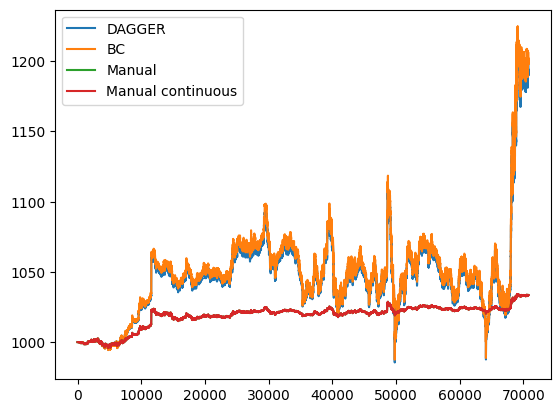

In [45]:
df_dagger = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/compare_clone_dagger.csv")
df_bc = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/compare_clone_bc.csv")

df_manual = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/manual_policy_integer.csv")
df_manual_cont = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/manual_continuous.csv")

plt.plot(df_dagger["value"], label="DAGGER")
plt.plot(df_bc["value"], label="BC")
plt.plot(df_manual["value"], label="Manual")
plt.plot(df_manual_cont["value"], label="Manual continuous")
plt.legend()
plt.show()

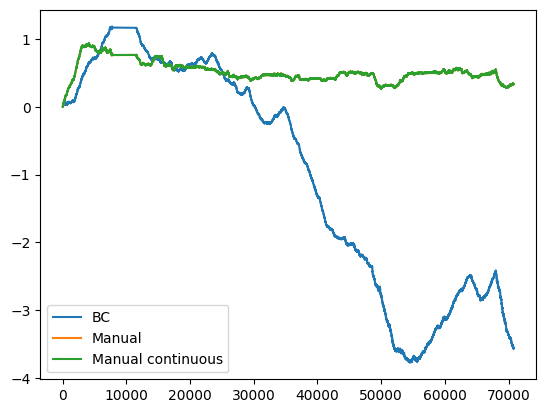

In [42]:
# plt.plot(df_dagger["value"], label="DAGGER")
plt.plot(df_bc["inventory"], label="BC")
plt.plot(df_manual["inventory"], label="Manual")
plt.plot(df_manual_cont["inventory"], label="Manual continuous")
plt.legend()
plt.show()

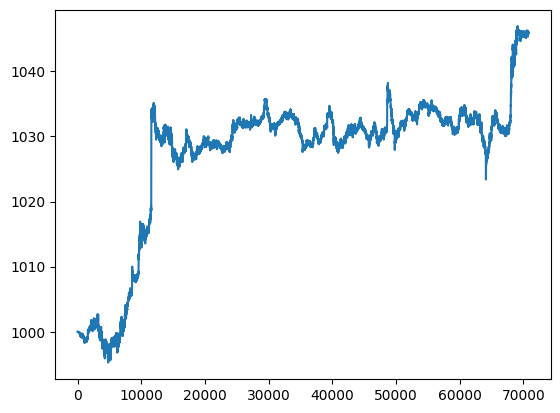

In [10]:
plt.plot(df["value"])



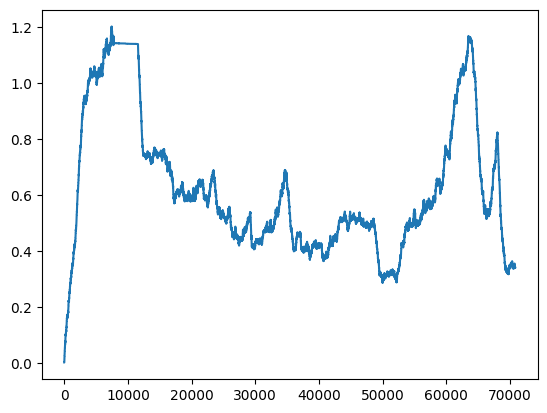

In [11]:
plt.plot(df["inventory"])


In [ ]:
# ts, x, y
arr = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
arr.tolist()

array([6, 9])

In [29]:
class OSIEstimator():
    def __init__(
        self,
        lookback=1000 * 60 * 60 * 24,
        update_interval=1000 * 60 * 60,
    ):
        lookback = lookback
        update_interval = update_interval
        buys = []
        sells = []
        previous_update = 0

    def update(self, trades):
        # trade is list of lists [[timestamp, price, amount, mid_price]]
        for trade in trades:
            ts, price, amount, mid_price = trade

            # sides are determined by price relative to mid_price, based on what side take is on
            if price < mid_price:
                sells.append(np.array([ts, amount]))
            elif price > mid_price:
                buys.append(np.array([ts, amount]))

    def calculate_values(self):
        """
        Function for calculating OSI. Currently updates OSI every hour.
        trade_bids/asks are two dimensional arrays formed like this [[timestamp, size]]
        This function sorts the trades by size and takes the 90% quantile sized trades for OSI calculation.
        """

        buy, sell = np.array(buys), np.array(sells)
        buy_qty, sell_qty = buy[:, 1], sell[:, 1]
        decile_buys = buy_qty[: (buy_qty < np.percentile(buy_qty, 90)).argmin()].sum()
        decile_sells = sell_qty[
            : (sell_qty < np.percentile(sell_qty, 90)).argmin()
        ].sum()

        osi = 100 * ((decile_buys - decile_sells) / (decile_buys + decile_sells))
        osi = osi

    def get_value(self, ts):
        if ts >= previous_update + update_interval:
            # prune trades that are too old
            buy_arr = np.array(buys)
            buys = buy_arr[buy_arr[:, 0] < (ts - lookback)].tolist()

            sell_arr = np.array(sells)
            sells = sell_arr[sell_arr[:, 0] < (ts - lookback)].tolist()

            calculate_values()
            previous_update = ts
        return osi
    
osi = OSIEstimator()
osi.update([[10, 10, 10, 0]])
osi.update([[20, 20, 20, 0]])

osi.update([[10, 10, 10, 40]])
osi.update([[20, 20, 20, 40]])
buy, sell = np.array(osi.buys), np.array(osi.sells)
buy_qty, sell_qty = buy[:, 1], sell[:, 1]


decile_buys = buy_qty[: (buy_qty < np.percentile(buy_qty, 90)).argmin()].sum()
decile_sells = sell_qty[
    : (sell_qty < np.percentile(sell_qty, 90)).argmin()
].sum()



0

In [31]:
import pandas as pd
import logging
import numpy as np
from scipy.optimize import curve_fit
import queue
import pandas as pd
import math


In [7]:
class VolatilityEstimator():
    """
    lookback: how far back (in milliseconds) to look at trades, default: 1 day
    return_aggregation: aggregation period for price returns (what is the time period between two price observations), default: 10 minutes
    update_interval: how often to update the estimator (in milliseconds), default: 1 minute
    """

    def __init__(
        self,
        lookback=(1000 * 60 * 60 * 24),
        return_aggregation=(1000 * 60 * 10),
        update_interval=(1000 * 60),
    ):
        lookback = lookback
        update_interval = update_interval
        return_aggregation = return_aggregation

        previous_ts = 0

        # prices = []
        prices = []

        volatility = 0
        previous_update = 0

    def update(self, new_price, ts):
        if ts >= previous_ts + return_aggregation:
            prices.append([ts, new_price])
            previous_ts = ts

    def calculate_volatility_real(self):
        """
        Vol = std(returns)
        Annualized vol = vol * sqrt(aggregation periods per year)
            - aggregation period is in milliseconds
        """
        a = np.array(price_queue.queue)
        return_arr = np.diff(a) / a[:, 1:]
        vol = np.std(return_arr)
        volatility = vol * np.sqrt(
            (1000 * 60 * 60 * 24 * 365) / return_aggregation
        )

    def calculate_values(self):
        """
        Calculates price volatility instead of percentage volatility
        """
        arr = np.array(prices)
        volatility = np.sqrt(np.sum(np.square(np.diff(arr))) / arr.size)

    def get_value(self, ts):
        if ts >= previous_update + update_interval:
            # prune old prices
            prices = np.array(prices)
            prices = prices[prices[:, 0] >= ts - lookback].tolist()
            calculate_values()
            previous_update = ts
        return volatility
    
vol = VolatilityEstimator(update_interval=0, return_aggregation=0)
vol.update(10, 100)
vol.update(11, 200)
np.array(vol.prices)[:,1]



array([10, 11])

In [45]:
base = pd.read_csv("/home/juuso/Documents/gradu/parsed_data/aggregated/base_data.csv")
indicators = pd.read_csv("/home/juuso/Documents/gradu/parsed_data/aggregated/indicator_data.csv")
data = pd.merge(base, indicators, on="timestamp", how='left').ffill().dropna()

In [79]:
len(data.to_numpy())

161113

In [93]:
envs = 3

current_step = np.array(range(3))
second_step = np.array([1])



current_step += 1
current_step

values = np.array(range(10)) * 10
print(values.shape, current_step.shape)
print(values[current_step])
print(values[second_step])

(10,) (3,)
[10 20 30]
[10]


In [108]:
a = np.array([1]).reshape(-1,1).T
b = np.array([2]).reshape(-1,1).T
c = np.array([3]).reshape(-1,1).T

print(np.concatenate([a,b,c]).T.shape)

a = np.array([1,2,3]).reshape(-1,1).T
b = np.array([4,5,6]).reshape(-1,1).T
c = np.array([7,8,9]).reshape(-1,1).T

np.concatenate([a,b,c]).T.shape

(1, 3)


(3, 3)

In [130]:
a = np.array([[1, 2], [3, 4]]).reshape(-1,1).T
a.reshape(4,)

array([1, 2, 3, 4])

In [161]:
data = 100
envs = 5
data_portion=0.3

if data_portion * envs < 1:
    start = np.array(range(envs)) * data_portion
    end = start + data_portion
    start_val = start * data
    end_val = end * data
    
else:
    offset = (1-data_portion) / (envs-1)
    start = np.array(range(envs)) * offset
    end = start + data_portion
    start_val = start * data
    end_val = end * data
    
    
start_val, end_val


(array([ 0. , 17.5, 35. , 52.5, 70. ]),
 array([ 30. ,  47.5,  65. ,  82.5, 100. ]))

In [5]:
# check if array has only one true value
a = np.array([True, False, False])
np

array([4, 5, 6])